# Stages of a simulation

This notebook is used to explain the components and stages of a simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the model!
from ohbemn import Region, wave

## Defining the environment

The environment consists of a infinite exterior domain and an interior domain defined by a region. The boundary separating the two environments is what this method simulates.

The difference between the two domains is their depth:

In [2]:
de = 10.0 # meters
di = 150.0 # meters

The region which defines the interior domain consists of a closed boundary of vertices (points) and edges (index-pairs of points = segments). The vertices and edges should be given in clock-wise order (assumed by the model to calculate the outward normal).

segments: 32


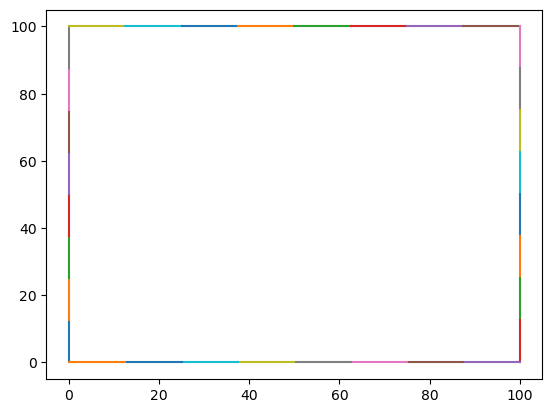

In [3]:
# We use the provided square example region

r = Region.square()

f, ax = plt.subplots()
r.plot(ax)

print("segments:", r.len())

## The source and its effect at the boundary

A source of waves drives the wavefield at the boundary of the region. This is described by the _boundary incidence_, and for each segment of the boundary we must know the value of wave field ($\phi$) and its spatial derivative ($\frac{\partial \phi}{\partial n} = v$). This is provided by the chosen source function (e.g. point source or plane wave).

In [4]:
freq = 0.5 # Hz

# Calculate phase speed, group speed and wave number for the interior and the exterior.
ci, cgi, ki = wave.wavec_interm(1/freq, di)
ce, cge, ke = wave.wavec_interm(1/freq, de)

# And wave length:
li = 1 / ki
le = 1 / ke

print(f'Interior: {ci=} m/s, {cgi=} m/s, {ki=} 1/m, {li=} m')
print(f'Exterior: {ce=} m/s, {cge=} m/s, {ke=} 1/m, {le=} m')

Interior: ci=array([3.12155365]) m/s, cgi=array([1.56091362]) m/s, ki=array([1.00641956]) 1/m, li=array([0.99362139]) m
Exterior: ce=array([3.12155363]) m/s, cge=array([1.56091361]) m/s, ke=array([1.00641957]) 1/m, le=array([0.99362138]) m


In this case lets start with dropping a giant pebble (stretching the definition of pebble) in the middle of the square. Let's imagine the square is a pool with hard edges around it. Hard edges reflect the waves, the velocity at the boundary is zero: that is a Neumann boundary condition.

## Point source for a 2D wave

A circular wave is described by:

$G(r_0, r) = \frac{i}{4} H_0^{(1)} (k |r - r_0|) $

To specify the Neumann conditions we need its derivative:

$\frac{\partial G}{\partial n}(r_0, r) -\frac{i}{4}  k \frac{\partial r}{\partial n}  H_0^{(1)} (k |r - r_0|) $

In an unbounded medium (free-field) this looks like:

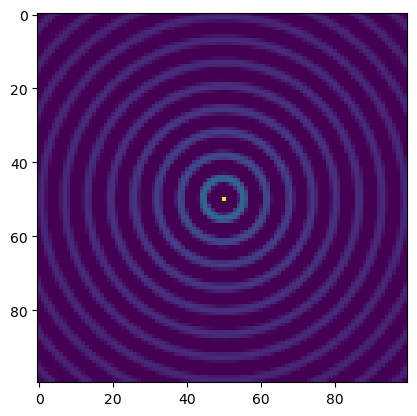

In [5]:
x = np.arange(0.1, 100, 1)
y = np.arange(0.1, 100, 1)
xx, yy = np.meshgrid(x, y)

# Source position
rx, ry = 50, 50

from scipy.special import hankel1

R = np.sqrt((rx-xx)**2 + (ry-yy)**2)
Fh = 1j/4 * hankel1(0, ki*R) # slightly infinite at rx, ry

f, ax = plt.subplots()
ax.imshow(np.real(Fh), vmin=0, vmax=1/4)

To find the derivative across the boundary (along the normal), we can use the chain-rule:

$ \frac{\partial G}{\partial n} = \frac{\partial G}{\partial r}\frac{\partial r}{\partial n} $

(see Sources.ipynb for more details). For this particular boundary and source function we must find:

$ \frac{\partial r}{\partial n} = \frac{\mathbf{r} \cdot \mathbf{n}}{r} $


In [6]:
from scipy.linalg import norm

# from: https://github.com/fjargsto/abem/blob/master/notebooks/exterior_helmholtz_solver_2d.ipynb
def drdn(x, s, scale):
    """
    assumes a square with one corner in (0,0) and the width and height in (scale, scale).
    """
    r = x - s
    R = norm(r)
    if x[0] <= 1e-7:
        drbdn = -r[0]/R
    elif x[0] >= scale - 1e-7:
        drbdn = r[0]/R
    elif x[1] <= 1e-7:
        drbdn = -r[1]/R
    elif x[1] >= scale - 1e-7:
        drbdn = r[1]/R
    else:
        assert False, "r = ({}, {}) not properly handled.".format(r[0], r[1])

    return drbdn


def dGdn(k, drdn, R):
    return -1j * k * drdn * hankel1(1, k*R) / 4.0

## Calculate Neumann boundary conditions at the center of each segment of our region

In [12]:
centers = r.centers()
bc = r.neumann_boundary_condition()

s = np.array([rx, ry]) # source position

for i in range(r.len()):
    x = centers[i, :]
    _drdn = drdn(x, s, 100.)
    R = norm(x-s)
    bc.f[i] = dGdn(ki, _drdn, R)


/tmp/ipykernel_105704/3902044083.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bc.f[i] = dGdn(ki, _drdn, R)


## Incident field

It is also possible to specify an incident field at the boundary. But in this case we only consider the internal source.

In [13]:
# Incident field is zero
bi = r.incident_field()

## Ready to solve the field

We now have everything we need to solve the boundary problem either in the interior, the exterior or at the boundary.